<!-- # Can we predict the financial loss ($M) of a cyberattack using factors such as attack method, data breached, and response time?

# https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/data -->

Can we predict the financial loss ($M) of a cyberattack using factors such as attack method, data breached, and response time?

https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/data


In [35]:
-88.906-(1.23e-16)+0.0297+(-2.025)+513.3

422.39869999999996

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, LeakyReLU  # Added LeakyReLU

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


In [37]:
df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")
df

Country  Year        Attack Type     Target Industry  \
0       China  2019           Phishing           Education   
1       China  2019         Ransomware              Retail   
2       India  2017  Man-in-the-Middle                  IT   
3          UK  2024         Ransomware  Telecommunications   
4     Germany  2018  Man-in-the-Middle                  IT   
...       ...   ...                ...                 ...   
2995       UK  2021         Ransomware          Government   
2996   Brazil  2023      SQL Injection  Telecommunications   
2997   Brazil  2017      SQL Injection                  IT   
2998       UK  2022      SQL Injection                  IT   
2999  Germany  2021      SQL Injection              Retail   

      Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                             80.53                    773169  Hacker Group   
1                             62.19                    295961  Hacker Group   
2                             38.65                    605895  Hacker Group   
3                             41.44                    659320  Nation-state   
4                             74.41                    810682       Insider   
...                             ...                       ...           ...   
2995                          51.42                    190694       Unknown   
2996                          30.28                    892843  Hacker Group   
2997                          32.97                    734737  Nation-state   
2998                          32.17                    379954       Insider   
2999                          48.20                    480984       Unknown   

     Security Vulnerability Type Defense Mechanism Used  \
0             Unpatched Software                    VPN   
1             Unpatched Software               Firewall   
2                 Weak Passwords                    VPN   
3             Social Engineering     AI-based Detection   
4             Social Engineering                    VPN   
...                          ...                    ...   
2995          Social Engineering               Firewall   
2996                    Zero-day                    VPN   
2997              Weak Passwords     AI-based Detection   
2998          Unpatched Software               Firewall   
2999                    Zero-day                    VPN   

      Incident Resolution Time (in Hours)  
0                                      63  
1                                      71  
2                                      20  
3                                       7  
4                                      68  
...                                   ...  
2995                                   52  
2996                                   26  
2997                                   30  
2998                                    9  
2999                                   64  

[3000 rows x 10 columns]

In [38]:
(df["Financial Loss (in Million $)"]<20).any()

np.True_

In [39]:
df.isna().any()

Country                                False
Year                                   False
Attack Type                            False
Target Industry                        False
Financial Loss (in Million $)          False
Number of Affected Users               False
Attack Source                          False
Security Vulnerability Type            False
Defense Mechanism Used                 False
Incident Resolution Time (in Hours)    False
dtype: bool

In [40]:
(df == 0).any()

Country                                False
Year                                   False
Attack Type                            False
Target Industry                        False
Financial Loss (in Million $)          False
Number of Affected Users               False
Attack Source                          False
Security Vulnerability Type            False
Defense Mechanism Used                 False
Incident Resolution Time (in Hours)    False
dtype: bool

<Axes: >

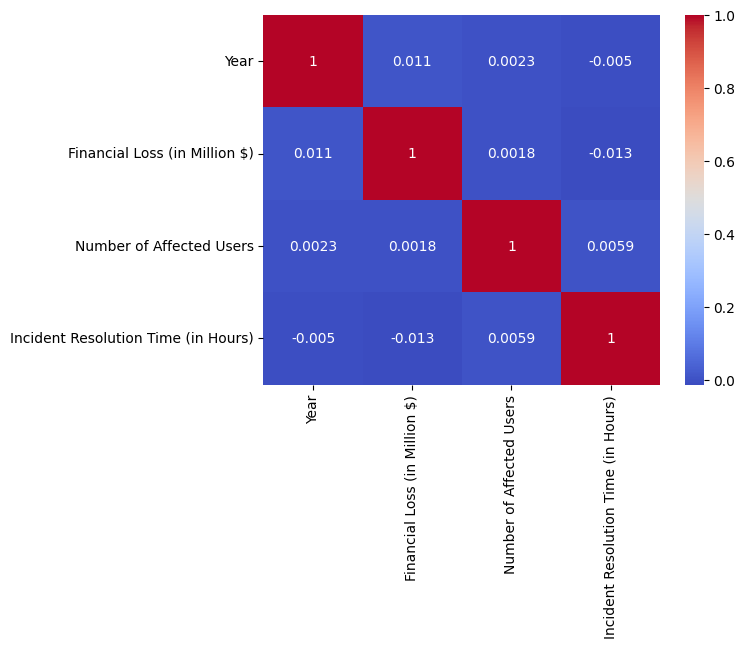

In [41]:
numeric_df = df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm') 

In [42]:
df.groupby("Attack Type")['Financial Loss (in Million $)'].mean().sort_values()



Attack Type
Malware              49.418454
Ransomware           49.653793
SQL Injection        50.013042
Phishing             50.459905
Man-in-the-Middle    51.309085
DDoS                 52.035631
Name: Financial Loss (in Million $), dtype: float64

In [43]:
df.groupby("Country")['Financial Loss (in Million $)'].mean().sort_values()


Country
India        47.292597
China        48.805943
France       49.089443
Japan        49.827344
Russia       49.948237
Brazil       50.911677
UK           51.411184
USA          51.610174
Australia    51.861953
Germany      54.272302
Name: Financial Loss (in Million $), dtype: float64

In [44]:
df.groupby("Target Industry")['Financial Loss (in Million $)'].mean().sort_values()


Target Industry
Education             47.903174
Healthcare            49.047296
Retail                49.928014
Telecommunications    50.766973
Banking               51.173910
IT                    51.903410
Government            52.618685
Name: Financial Loss (in Million $), dtype: float64

In [45]:
df.groupby("Security Vulnerability Type")['Financial Loss (in Million $)'].mean().sort_values()

Security Vulnerability Type
Unpatched Software    50.168604
Zero-day              50.380306
Weak Passwords        50.519726
Social Engineering    50.905676
Name: Financial Loss (in Million $), dtype: float64

In [46]:
df.groupby("Attack Source")['Financial Loss (in Million $)'].mean().sort_values()


Attack Source
Insider         48.767965
Unknown         50.534648
Nation-state    51.004055
Hacker Group    51.745729
Name: Financial Loss (in Million $), dtype: float64

In [47]:
df.groupby("Defense Mechanism Used")['Financial Loss (in Million $)'].mean().sort_values()

Defense Mechanism Used
Firewall              49.719709
VPN                   50.209673
AI-based Detection    50.361527
Encryption            50.400203
Antivirus             51.698838
Name: Financial Loss (in Million $), dtype: float64

In [48]:
df.columns

Index(['Country', 'Year', 'Attack Type', 'Target Industry',
       'Financial Loss (in Million $)', 'Number of Affected Users',
       'Attack Source', 'Security Vulnerability Type',
       'Defense Mechanism Used', 'Incident Resolution Time (in Hours)'],
      dtype='object')

In [49]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



In [50]:

df['id'] = range(1, len(df) + 1) 

# Reuse your raw (non-encoded) df
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata.set_primary_key('id')

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)

synthetic_data = synthesizer.sample(num_rows=3000)
synthetic_data

c:\ProgramData\Workspace\github\AI4ALL Project\ai4allG16D\cyber_finloss_predictor.venv\Lib\site-packages\sdv\metadata\single_table.py:835: UserWarning: There is an existing primary key 'id'. This key will be removed.
  warnings.warn(
c:\ProgramData\Workspace\github\AI4ALL Project\ai4allG16D\cyber_finloss_predictor.venv\Lib\site-packages\sdv\single_table\base.py:163: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\ProgramData\Workspace\github\AI4ALL Project\ai4allG16D\cyber_finloss_predictor.venv\Lib\site-packages\sdv\single_table\base.py:129: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Country  Year        Attack Type     Target Industry  \
0     Australia  2023           Phishing           Education   
1       Germany  2017         Ransomware              Retail   
2        Russia  2021         Ransomware             Banking   
3         Japan  2018  Man-in-the-Middle                  IT   
4        France  2020            Malware             Banking   
...         ...   ...                ...                 ...   
2995      India  2018            Malware           Education   
2996  Australia  2015            Malware          Healthcare   
2997     France  2019      SQL Injection              Retail   
2998      China  2016           Phishing  Telecommunications   
2999      China  2021            Malware                  IT   

      Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                             32.98                    668857       Insider   
1                             17.29                    139507  Hacker Group   
2                             12.57                    317004       Unknown   
3                             13.95                    140782       Unknown   
4                             69.56                    862347  Nation-state   
...                             ...                       ...           ...   
2995                          45.10                     85649       Unknown   
2996                          81.03                     12956  Hacker Group   
2997                          25.49                    562082  Hacker Group   
2998                          87.88                    466108  Nation-state   
2999                          57.44                    520310       Insider   

     Security Vulnerability Type Defense Mechanism Used  \
0             Social Engineering              Antivirus   
1             Social Engineering             Encryption   
2                       Zero-day                    VPN   
3                 Weak Passwords              Antivirus   
4                       Zero-day     AI-based Detection   
...                          ...                    ...   
2995          Unpatched Software              Antivirus   
2996          Unpatched Software             Encryption   
2997                    Zero-day             Encryption   
2998          Unpatched Software              Antivirus   
2999          Unpatched Software             Encryption   

      Incident Resolution Time (in Hours)        id  
0                                      14   5451002  
1                                      45   6046429  
2                                      19  11509909  
3                                      59   7602670  
4                                      32   5066721  
...                                   ...       ...  
2995                                   67  14818859  
2996                                   34  11261031  
2997                                   26   6098281  
2998                                   16  15009742  
2999                                   43  14944783  

[3000 rows x 11 columns]

In [51]:
# check if financial loss is greater than 0.5 Mil
synthetic_data = synthetic_data[synthetic_data["Financial Loss (in Million $)"]>=0.5]
synthetic_data

Country  Year        Attack Type     Target Industry  \
0     Australia  2023           Phishing           Education   
1       Germany  2017         Ransomware              Retail   
2        Russia  2021         Ransomware             Banking   
3         Japan  2018  Man-in-the-Middle                  IT   
4        France  2020            Malware             Banking   
...         ...   ...                ...                 ...   
2995      India  2018            Malware           Education   
2996  Australia  2015            Malware          Healthcare   
2997     France  2019      SQL Injection              Retail   
2998      China  2016           Phishing  Telecommunications   
2999      China  2021            Malware                  IT   

      Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                             32.98                    668857       Insider   
1                             17.29                    139507  Hacker Group   
2                             12.57                    317004       Unknown   
3                             13.95                    140782       Unknown   
4                             69.56                    862347  Nation-state   
...                             ...                       ...           ...   
2995                          45.10                     85649       Unknown   
2996                          81.03                     12956  Hacker Group   
2997                          25.49                    562082  Hacker Group   
2998                          87.88                    466108  Nation-state   
2999                          57.44                    520310       Insider   

     Security Vulnerability Type Defense Mechanism Used  \
0             Social Engineering              Antivirus   
1             Social Engineering             Encryption   
2                       Zero-day                    VPN   
3                 Weak Passwords              Antivirus   
4                       Zero-day     AI-based Detection   
...                          ...                    ...   
2995          Unpatched Software              Antivirus   
2996          Unpatched Software             Encryption   
2997                    Zero-day             Encryption   
2998          Unpatched Software              Antivirus   
2999          Unpatched Software             Encryption   

      Incident Resolution Time (in Hours)        id  
0                                      14   5451002  
1                                      45   6046429  
2                                      19  11509909  
3                                      59   7602670  
4                                      32   5066721  
...                                   ...       ...  
2995                                   67  14818859  
2996                                   34  11261031  
2997                                   26   6098281  
2998                                   16  15009742  
2999                                   43  14944783  

[3000 rows x 11 columns]

In [52]:
synthetic_data.drop(columns='id', inplace=True, errors='ignore')

# Optional: remove id from original too
df.drop(columns='id', inplace=True, errors='ignore')

#  Combine datasets
df_augmented = pd.concat([df, synthetic_data], ignore_index=True)

df_augmented

Country  Year        Attack Type     Target Industry  \
0         China  2019           Phishing           Education   
1         China  2019         Ransomware              Retail   
2         India  2017  Man-in-the-Middle                  IT   
3            UK  2024         Ransomware  Telecommunications   
4       Germany  2018  Man-in-the-Middle                  IT   
...         ...   ...                ...                 ...   
5995      India  2018            Malware           Education   
5996  Australia  2015            Malware          Healthcare   
5997     France  2019      SQL Injection              Retail   
5998      China  2016           Phishing  Telecommunications   
5999      China  2021            Malware                  IT   

      Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                             80.53                    773169  Hacker Group   
1                             62.19                    295961  Hacker Group   
2                             38.65                    605895  Hacker Group   
3                             41.44                    659320  Nation-state   
4                             74.41                    810682       Insider   
...                             ...                       ...           ...   
5995                          45.10                     85649       Unknown   
5996                          81.03                     12956  Hacker Group   
5997                          25.49                    562082  Hacker Group   
5998                          87.88                    466108  Nation-state   
5999                          57.44                    520310       Insider   

     Security Vulnerability Type Defense Mechanism Used  \
0             Unpatched Software                    VPN   
1             Unpatched Software               Firewall   
2                 Weak Passwords                    VPN   
3             Social Engineering     AI-based Detection   
4             Social Engineering                    VPN   
...                          ...                    ...   
5995          Unpatched Software              Antivirus   
5996          Unpatched Software             Encryption   
5997                    Zero-day             Encryption   
5998          Unpatched Software              Antivirus   
5999          Unpatched Software             Encryption   

      Incident Resolution Time (in Hours)  
0                                      63  
1                                      71  
2                                      20  
3                                       7  
4                                      68  
...                                   ...  
5995                                   67  
5996                                   34  
5997                                   26  
5998                                   16  
5999                                   43  

[6000 rows x 10 columns]

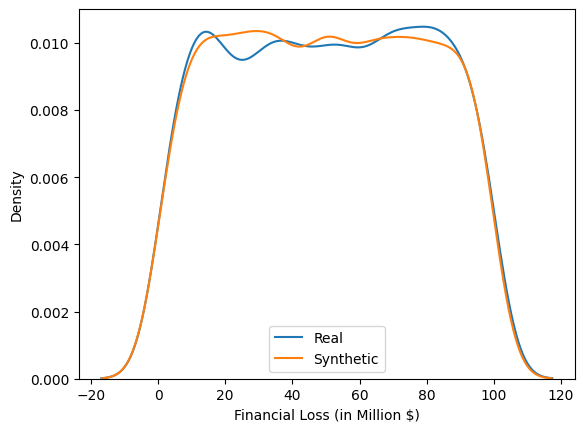

In [53]:
sns.kdeplot(df["Financial Loss (in Million $)"], label="Real")
sns.kdeplot(synthetic_data["Financial Loss (in Million $)"], label="Synthetic")
plt.legend()
plt.show()

In [54]:
categorical_cols = ['Country', 'Attack Type', 'Target Industry', 'Attack Source',
                    'Security Vulnerability Type', 'Defense Mechanism Used']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df_augmented, columns=categorical_cols, drop_first=True)

df_encoded

Year  Financial Loss (in Million $)  Number of Affected Users  \
0     2019                          80.53                    773169   
1     2019                          62.19                    295961   
2     2017                          38.65                    605895   
3     2024                          41.44                    659320   
4     2018                          74.41                    810682   
...    ...                            ...                       ...   
5995  2018                          45.10                     85649   
5996  2015                          81.03                     12956   
5997  2019                          25.49                    562082   
5998  2016                          87.88                    466108   
5999  2021                          57.44                    520310   

      Incident Resolution Time (in Hours)  Country_Brazil  Country_China  \
0                                      63           False           True   
1                                      71           False           True   
2                                      20           False          False   
3                                       7           False          False   
4                                      68           False          False   
...                                   ...             ...            ...   
5995                                   67           False          False   
5996                                   34           False          False   
5997                                   26           False          False   
5998                                   16           False           True   
5999                                   43           False           True   

      Country_France  Country_Germany  Country_India  Country_Japan  ...  \
0              False            False          False          False  ...   
1              False            False          False          False  ...   
2              False            False           True          False  ...   
3              False            False          False          False  ...   
4              False             True          False          False  ...   
...              ...              ...            ...            ...  ...   
5995           False            False           True          False  ...   
5996           False            False          False          False  ...   
5997            True            False          False          False  ...   
5998           False            False          False          False  ...   
5999           False            False          False          False  ...   

      Attack Source_Insider  Attack Source_Nation-state  \
0                     False                       False   
1                     False                       False   
2                     False                       False   
3                     False                        True   
4                      True                       False   
...                     ...                         ...   
5995                  False                       False   
5996                  False                       False   
5997                  False                       False   
5998                  False                        True   
5999                   True                       False   

      Attack Source_Unknown  Security Vulnerability Type_Unpatched Software  \
0                     False                                            True   
1                     False                                            True   
2                     False                                           False   
3                     False                                           False   
4                     False                                           False   
...                     ...                                             ...   
5995                   True                                      

In [55]:
# Select features
X = df_encoded.drop(columns=['Financial Loss (in Million $)']) 
y = df_encoded['Financial Loss (in Million $)']

In [56]:


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [57]:

# Reduced hidden layers, increased learning rate, added LeakyReLU and BatchNorm for stability
model = Sequential([
    Dense(64, input_dim=X_train.shape[1]),  # Fewer units, no activation yet
    BatchNormalization(),                   # Normalize activations
    LeakyReLU(alpha=0.01),                  # LeakyReLU activation
    Dropout(0.2),                           # Dropout for regularization
    Dense(1)                                # Output layer for regression
])

learning_rate = 0.002  # Increased learning rate for faster convergence
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


c:\ProgramData\Workspace\github\AI4ALL Project\ai4allG16D\cyber_finloss_predictor.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\ProgramData\Workspace\github\AI4ALL Project\ai4allG16D\cyber_finloss_predictor.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [58]:
# less hidden layers
# switch it to leakyRelu


In [59]:


early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop, reduce_lr])




Epoch 1/100


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3058 - mae: 0.9534 - val_loss: 1.1085 - val_mae: 0.9050 - learning_rate: 0.0020
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1071 - mae: 0.8894 - val_loss: 1.0827 - val_mae: 0.9009 - learning_rate: 0.0020
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0378 - mae: 0.8671 - val_loss: 1.0730 - val_mae: 0.9012 - learning_rate: 0.0020
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9999 - mae: 0.8542 - val_loss: 1.0661 - val_mae: 0.8989 - learning_rate: 0.0020
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9819 - mae: 0.8486 - val_loss: 1.0696 - val_mae: 0.9009 - learning_rate: 0.0020
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9679 - mae: 0.8436 - val_loss: 1.0862 - val_mae: 0.9081 - learning_rate: 0.0020
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9716 - mae: 0.8473 - val_loss: 1.0801 - val_mae: 0.9054 - learning_rate: 0.0020
Epoch 8/100

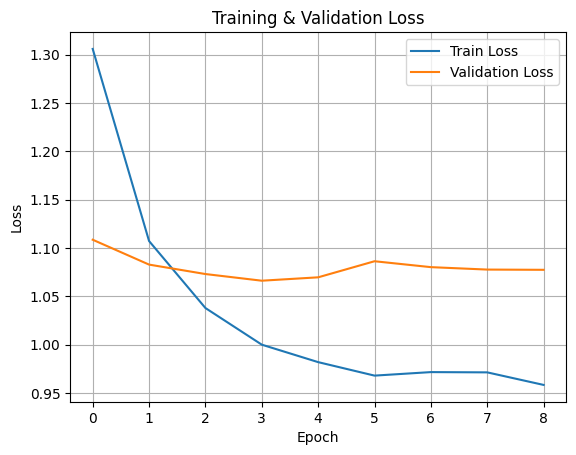

In [60]:
# Plot loss

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# model = Sequential([
#     Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])

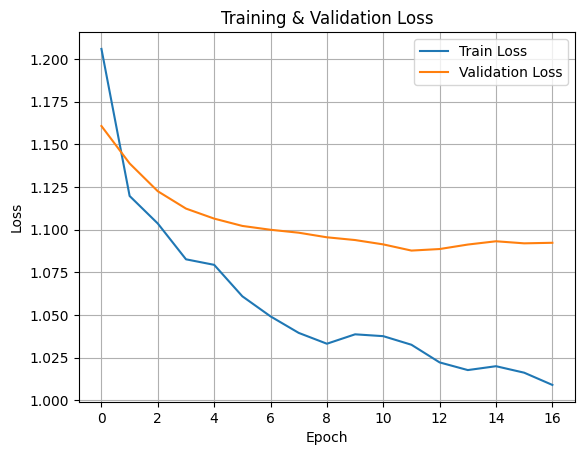

In [62]:



plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [63]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")
print(f"Test loss: {loss:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0390 - mae: 0.8743 
Test MAE: 0.87
Test loss: 1.04


In [64]:
print(y.min(), y.max(), y.mean(), y.std())

0.5 99.99 50.29237833333334 28.675050022784013


In [65]:
y_pred_scaled = model.predict(X_test)

y_pred_orig = y_scaler.inverse_transform(y_pred_scaled)
y_test_orig = y_scaler.inverse_transform(y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [66]:


mae_real = mean_absolute_error(y_test_orig, y_pred_orig)
mse_real = mean_squared_error(y_test_orig, y_pred_orig)
rmse_real = np.sqrt(mse_real)

print(f"Real MAE: {mae_real:.2f}")
print(f"Real RMSE: {rmse_real:.2f}")

Real MAE: 24.99
Real RMSE: 29.13


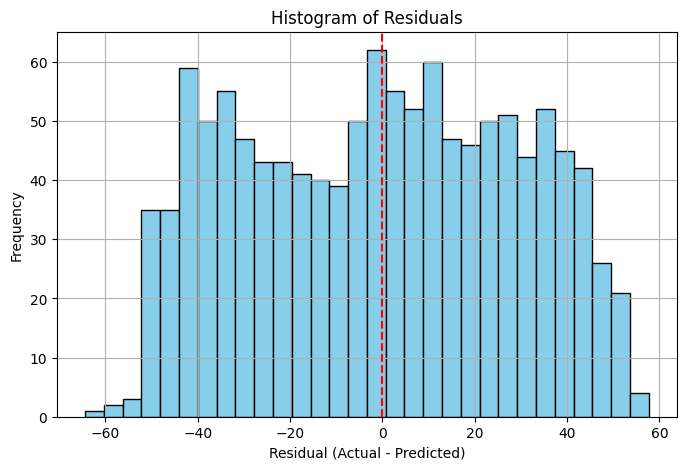

In [67]:
residuals = y_test_orig.flatten() - y_pred_orig.flatten()

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Ridge regression


include runtime in the write up (comparing both models)
computation cost (drawing from the runtime)


In [ ]:

# Tune alpha using cross-validation for best performance
alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Train Ridge with best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)  # Fit model to training data

y_pred = ridge.predict(X_test)  # Predict on test set

mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Ridge Regression MAE: {mae:.2f}")
print(f"Ridge Regression RMSE: {rmse:.2f}")

Ridge Regression MAE: 0.88
Ridge Regression RMSE: 1.03
